In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy.special import gamma
import tqdm
from maxpy.makegif import make_gif

def cback(data, name):
    plt.clf()
    plt.xlim(-2, 2)
    plt.ylim(-2, 2)
    plt.scatter(data[0][:, 0], data[0][:, 1], c=data[1])
    plt.savefig(name)

# two different kernels, a Gaussian and a spline
# Gaussian kernel
def W(x, y, z, h):
    """
    Gausssian kernel in 3D
        x,y,z     list of positions in x, y, z
        h         smoothing length

        return    smoothing function
    """

    r = np.sqrt(x**2 + y**2 + z**2)

    return (1.0 / (h * np.sqrt(np.pi))) ** 3 * np.exp(-(r**2) / h**2)


# derivative of Gaussian kernel
def grad_W(x, y, z, h):
    """
    Gradient of the Gausssian kernel W
    x,y,z     list of positions in x, y, z
    h         smoothing length
    wx,wy,wz  gradient of W
    """

    r = np.sqrt(x**2 + y**2 + z**2)

    n = -2.0 * np.exp(-(r**2) / h**2) / h**5 / (np.pi) ** (3.0 / 2.0)
    dwx = n * x
    dwy = n * y
    dwz = n * z

    return dwx, dwy, dwz


def compute_pairwise_distances(ri, rj):
    """
    compute pairwise separations between 2 sets of coordinates
    ri    is an M x 3 matrix of positions
    rj    is an N x 3 matrix of positions
    dx, dy, dz   are M x N matrices of separations
    """

    M = ri.shape[0]
    N = rj.shape[0]

    # positions ri = (x,y,z)
    rix = ri[:, 0].reshape((M, 1))
    riy = ri[:, 1].reshape((M, 1))
    riz = ri[:, 2].reshape((M, 1))

    # other set of points positions rj = (x,y,z)
    rjx = rj[:, 0].reshape((N, 1))
    rjy = rj[:, 1].reshape((N, 1))
    rjz = rj[:, 2].reshape((N, 1))

    # matrices that store all pairwise particle separations: r_i - r_j
    dx = rix - rjx.T
    dy = riy - rjy.T
    dz = riz - rjz.T

    return dx, dy, dz


def compute_density(r, pos, m, h):
    """
    Compute density at sampling loctions from SPH particle distribution
    r     is an M x 3 matrix of sampling locations
    pos   is an N x 3 matrix of SPH particle positions
    m     is the particle mass
    h     is the smoothing length
    rho   is M x 1 vector of densities
    """

    M = r.shape[0]

    dx, dy, dz = compute_pairwise_distances(r, pos)

    rho = np.sum(m * W(dx, dy, dz, h), 1).reshape((M, 1))

    return rho


def compute_pressure(rho, k, n):
    """
    equation of state
    rho   vector of densities
    k     constant for the equation of state
    n     polytropic index
    """

    return k * rho ** (1 + 1 / n)


def compute_accelerations(pos, vel, m, h, k, n, Fext, nu):
    """
    calculate the acceleration on each SPH particle
    pos   is an N x 3 matrix of positions
    vel   is an N x 3 matrix of velocities
    m     is the particle mass
    h     is the smoothing length
    k     constant for the equation of state
    n     polytropic index
    Fext  external force constant
    nu    viscosity
    a     is N x 3 matrix of accelerations
    """

    N = pos.shape[0]

    # Calculate densities at the position of the particles
    rho = compute_density(pos, pos, m, h)

    # Get the pressures
    P = compute_pressure(rho, k, n)

    # Get pairwise distances and gradients
    dx, dy, dz = compute_pairwise_distances(pos, pos)
    dWx, dWy, dWz = grad_W(dx, dy, dz, h)

    # Calculate the pressure gradient
    tmp = P / rho**2
    pj, pi = np.meshgrid(tmp, tmp)

    # Add Pressure contribution to accelerations
    ax = -np.sum(m * (pi + pj) * dWx, axis=1)
    ay = -np.sum(m * (pi + pj) * dWy, axis=1)
    az = -np.sum(m * (pi + pj) * dWz, axis=1)

    # pack together the acceleration components
    a = np.vstack((ax, ay, az)).T

    # Add external potential force
    a -= Fext * pos

    # Add viscosity
    a -= nu * vel

    return a

In [39]:
def run_simulation(tEnd=12, dt=0.04, N=400, h=0.1, nu=1):
    """parameters for the main simulation funcion
    tEnd   : end time
    dt     : time step
    N      : number of particles
    h      : globally constant smoothing length
    nu     : artificial viscosity
    """

    # Main simulation parameters
    t = 0  # current time of the simulation
    M = 2  # star mass
    R = 0.75  # star radius
    k = 0.1  # equation of state constant
    n = 1  # polytropic index

    # Generate Initial Conditions
    np.random.seed(42)  # set the random number generator seed

    Fext = (
        2 * k * (1 + n) * np.pi ** (-3 / (2 * n)) * (M * gamma(5 / 2 + n) / R**3 / gamma(1 + n)) ** (1 / n) / R**2
    )  # ~ 2.01
    m = M / N  # single particle mass
    pos = np.random.randn(N, 3)  # randomly selected positions and velocities
    vel = np.zeros(pos.shape)

    # calculate initial gravitational accelerations
    acc = compute_accelerations(pos, vel, m, h, k, n, Fext, nu)

    # number of timesteps
    Nt = int(np.ceil(tEnd / dt))

    result = []

    resolution = 128
    lin = np.linspace(-2, 2, resolution)
    x, y = np.meshgrid(lin, lin)
    r = np.array([x.flatten(), y.flatten(), np.zeros(x.shape).flatten()]).T

    # Simulation Main Loop
    for i in tqdm.tqdm(range(Nt)):
        # kick-drift-kick
        # Kick
        vel += 0.5 * acc * dt

        # Drift
        pos += vel * dt

        # Calculate new acceleration
        acc = compute_accelerations(pos, vel, m, h, k, n, Fext, nu)

        # Kick
        vel += 0.5 * acc * dt

        # update time
        t += dt

        # get density for plotting
        rho = compute_density(pos, pos, m, h)

        # get density for image
        # rho_plot = compute_density(r, pos, m, h).reshape((resolution, resolution))

        result.append([pos.copy(), rho.copy(), vel.copy()])
        # result.append(rho_plot.copy())

    return result

  0%|          | 0/300 [00:00<?, ?it/s]

100%|██████████| 300/300 [00:01<00:00, 217.10it/s]


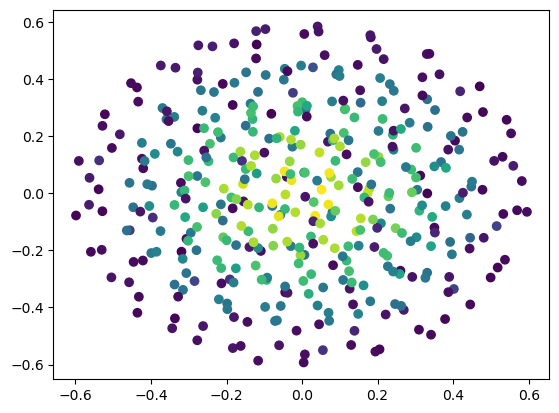

In [65]:
result = run_simulation(tEnd=12.0, dt=0.04, N=400, h=0.1, nu=1.0)

# create final figure with positions of particles and density coloour coded
plt.scatter(result[-1][0][:, 0], result[-1][0][:, 1], c=result[-1][1])
plt.show()

In [66]:
make_gif(cback, result, "sph_nu1.gif")

Save Images...


100%|██████████| 300/300 [00:00<00:00, 348.35it/s]


Done.
Make Gif...


100%|██████████| 300/300 [00:00<00:00, 444.49it/s]


Done.


![/home/max/Nextcloud/SimulationMethods/Exercise12/sph_nu1.gif](/home/max/Nextcloud/SimulationMethods/Exercise12/sph_nu1.gif)

100%|██████████| 300/300 [00:01<00:00, 158.23it/s]


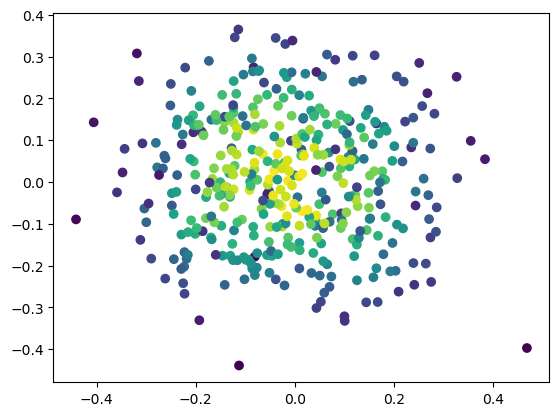

In [68]:
result = run_simulation(tEnd=12.0, dt=0.04, N=400, h=0.1, nu=0.0)

# create final figure with positions of particles and density coloour coded
plt.scatter(result[-1][0][:, 0], result[-1][0][:, 1], c=result[-1][1])
plt.show()

In [69]:
make_gif(cback, result, "sph_nu0.gif")

Save Images...


100%|██████████| 300/300 [00:00<00:00, 337.40it/s]


Done.
Make Gif...


100%|██████████| 300/300 [00:00<00:00, 399.27it/s]


Done.


![/home/max/Nextcloud/SimulationMethods/Exercise12/sph_nu0.gif](/home/max/Nextcloud/SimulationMethods/Exercise12/sph_nu0.gif)

100%|██████████| 500/500 [00:02<00:00, 217.10it/s]


(21,)


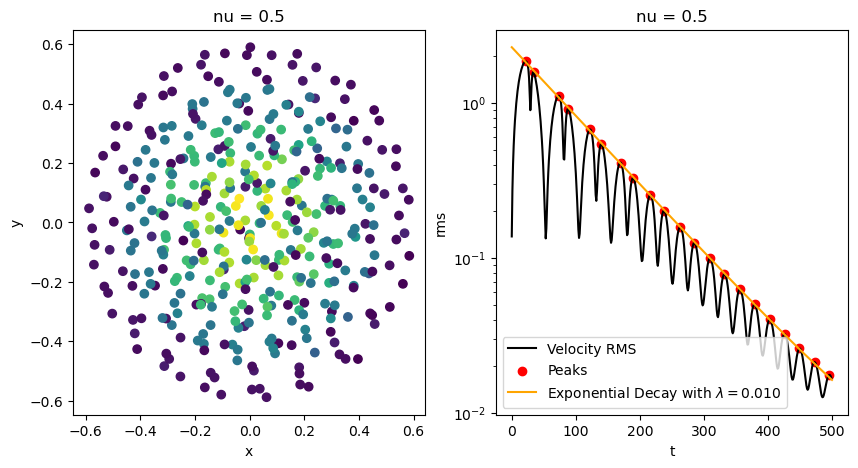

100%|██████████| 500/500 [00:02<00:00, 220.28it/s]


(16,)


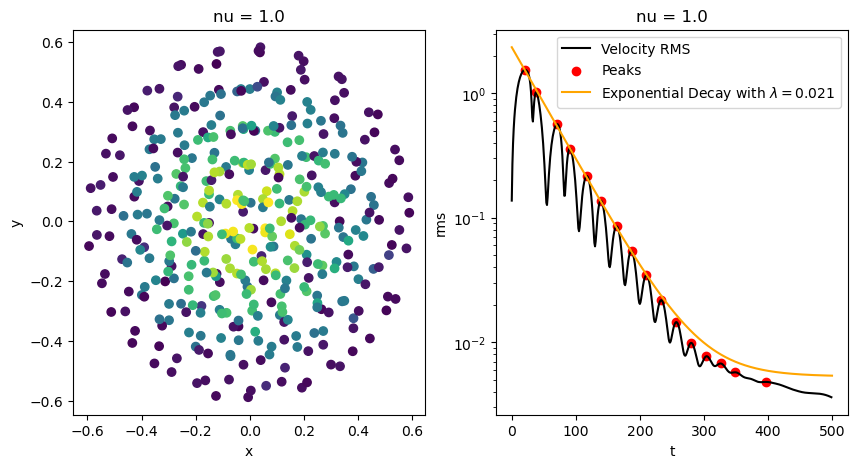

100%|██████████| 500/500 [00:02<00:00, 218.41it/s]


(7,)


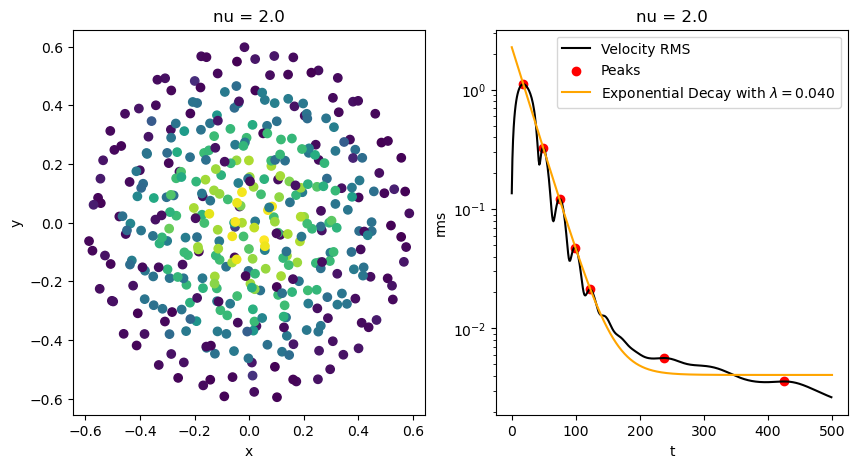

In [63]:
from scipy.signal import find_peaks
from scipy.optimize import curve_fit

viscosities = [0.5, 1.0, 2.0]

for nu in viscosities:
    result = run_simulation(tEnd=20.0, dt=0.04, N=400, h=0.1, nu=nu)

    # Root mean square velocity
    vels = np.array([np.sum(result[i][2] ** 2, axis=1) for i in range(len(result))])
    rms = np.sqrt(np.mean(vels, axis=1))

    # Plot the final positions
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    ax[0].scatter(result[-1][0][:, 0], result[-1][0][:, 1], c=result[-1][1])
    ax[0].set_title(f"nu = {nu}")
    ax[0].set_xlabel("x")
    ax[0].set_ylabel("y")

    # Find peaks in the rms data
    peaks, _ = find_peaks(rms)

    # Define the exponential decay function
    def exponential_decay(x, a, b, c):
        return a * np.exp(-b * x) + c

    # Fit the exponential decay curve onto the peaks
    x_data = np.arange(len(rms))[peaks]
    y_data = rms[peaks]
    popt, pcov = curve_fit(exponential_decay, x_data, y_data, p0=[2.5, 0.01, 1])
    xlin = np.linspace(0, len(rms), 1000)

    # Plot the rms data and the fitted curve
    ax[1].plot(np.arange(len(rms)), rms, "black", label="Velocity RMS")
    # Plot the peaks
    ax[1].scatter(peaks, rms[peaks], color="red", label="Peaks")
    ax[1].plot(
        xlin,
        exponential_decay(xlin, *popt),
        color="orange",
        label="Exponential Decay with $\lambda=${:.3f}".format(popt[1]),
    )
    ax[1].set_xlabel("t")
    ax[1].set_ylabel("rms")
    ax[1].set_title(f"nu = {nu}")
    ax[1].set_yscale("log")
    ax[1].legend()

    plt.show()

In [23]:
from maxpy.makegif import make_gif


def cback(data, name):
    plt.clf()
    plt.imshow(data[0], cmap="cmr.sunburst")
    plt.savefig(name)


make_gif(cback, result)

Save Images...


100%|██████████| 150/150 [00:00<00:00, 321.87it/s]


Done.
Make Gif...


100%|██████████| 150/150 [00:00<00:00, 405.41it/s]


Done.


(256, 256)


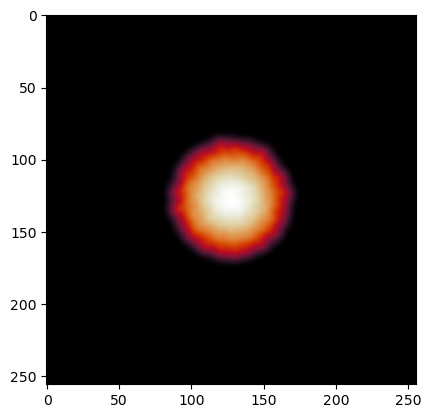

In [19]:
import cmasher as cmr

print(result[-1][0].shape)
plt.imshow(result[-1][0], cmap="cmr.sunburst")